<a href="https://colab.research.google.com/github/ambideXtrous9/T5-FineTuned-Model-for-NewsQA/blob/main/NewsQA_FLAN_T5_model-METEOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Apr 18 04:32:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet tokenizers
!pip install --quiet rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.4 MB/s eta 0:00:00


# **Import packages**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import nltk
nltk.download('wordnet')
nltk.download('wordnet_ic')
nltk.download('punkt')
from nltk.translate.meteor_score import meteor_score as meteor
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk import word_tokenize
from rouge import Rouge


from torch.optim import AdamW

from transformers import (AutoTokenizer as Tokenizer , AutoModelForSeq2SeqLM)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
pl.seed_everything (42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# **Dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/MTP CODE/NewsQA_SPAN.feather'

In [7]:
df = pd.read_feather(path)
df

,question,answer,ans_pos,paragraph,answer_start,answer_end
0,Who is the managing director of Synergee Capital?,Vikram Dalal,"[133, 145]","""Investors can use a combination of governmen...",133,145
1,What is the yield of 30- and 40-year governmen...,7%,"[565, 567]","""Investors can use a combination of governmen...",565,567
2,What is the name of the ETF 2027 that a conser...,SDL,"[209, 212]","According to financial planners, an example o...",209,212
3,When would a conservative fixed income investo...,2027,"[217, 221]","According to financial planners, an example o...",217,221
4,What year would a conservative fixed income in...,2040,"[260, 264]","According to financial planners, an example o...",260,264
...,...,...,...,...,...,...
481753,When does Uncle Sam reopen for fully vaccinate...,November 8,"[295, 305]",NEW DELHI: This could be the last expansion of...,295,305
481754,When will there be three more weekly flights b...,from second week of November,"[116, 144]",It currently has 23 weekly flights to America....,116,144
481755,What type of 777s would have helped AI have mo...,Boeing,"[306, 312]",It currently has 23 weekly flights to America....,306,312
481756,What was the first wave of AI nonstops?,second,"[11, 17]","Before the second wave this summer, AI had abo...",11,17


In [8]:
df['len_ans'] = df['answer'].apply(lambda x: len(x.split()))
df['len_ques'] = df['question'].apply(lambda x: len(x.split()))

In [9]:
max_index = df['len_ans'].idxmax()
sample = df.iloc[max_index]
print(sample['answer'])
print(sample['len_ans'])

July 18, July 24, July 29, August 2, August 4, August 8, August 11, August 12, August 13, August 16, August 20, August 21, August 22, August 23 and August 24, August 26, August 27, August 28 and August 29
40


In [10]:
min_index = df['len_ans'].idxmin()
sample = df.iloc[min_index]
print(sample['answer'])
print(sample['len_ans'])

7%
1


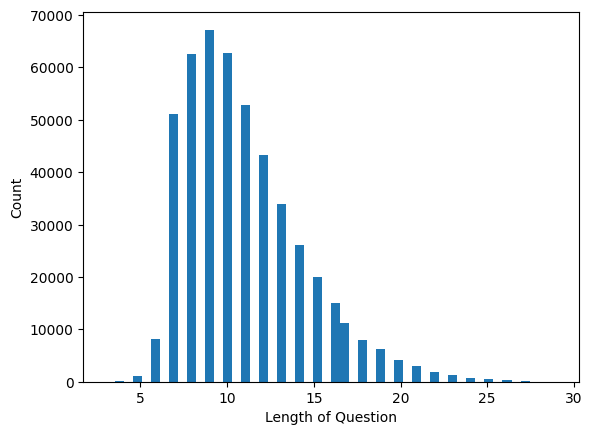

In [11]:
# Plot histogram of length column
plt.hist(df['len_ques'], bins=50)
# Set x and y labels
plt.xlabel('Length of Question')
plt.ylabel('Count')

# Show the plot
plt.show()

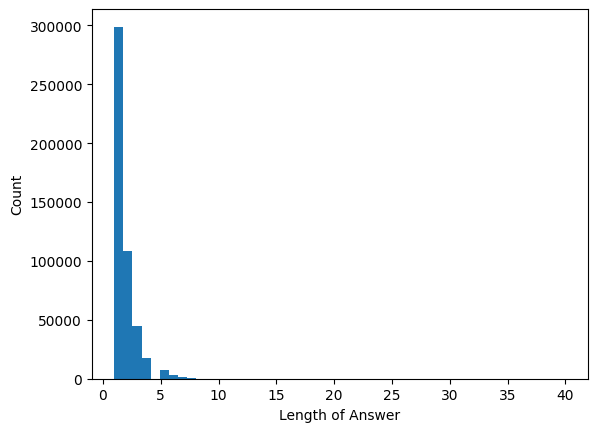

In [12]:
# Plot histogram of length column
plt.hist(df['len_ans'], bins=50)
# Set x and y labels
plt.xlabel('Length of Answer')
plt.ylabel('Count')

# Show the plot
plt.show()

In [13]:
df = df.iloc[:5000]

# **Tokenization**

In [14]:
MODEL_NAME = 'google/flan-t5-small'

In [15]:
tokenizer = Tokenizer.from_pretrained(MODEL_NAME)

In [16]:
class NQADataset(Dataset):
  def __init__(self,data : pd.DataFrame,tokenizer : Tokenizer,source_max_token_len : int = 400,target_max_token_len : int = 32):

    self.tokenizer = tokenizer
    self.data = data
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index : int):
    data_row = self.data.iloc[index]

    source_encoding = tokenizer(
        data_row['question'],
        data_row['paragraph'],
        max_length = self.source_max_token_len,
        padding = "max_length",
        truncation = "only_second",
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    target_encoding = tokenizer(
        data_row['answer'],
        max_length = self.target_max_token_len,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    labels = target_encoding["input_ids"]
    labels[labels == 0] = -100

    return dict(
        answer = data_row['answer'],
        input_ids = source_encoding['input_ids'].flatten(),
        attention_mask = source_encoding['attention_mask'].flatten(),
        labels = labels.flatten())

In [17]:
sample_dataset = NQADataset(df,tokenizer)

In [18]:
for data in sample_dataset:
  print(data['answer'])
  print(data['input_ids'][:10])
  print(data['labels'][:10])
  break


Vikram Dalal
tensor([2645,   19,    8, 5037, 2090,   13, 8951,   49,  397,   15])
tensor([ 1813,   157,  2375, 10729,   138,     1,  -100,  -100,  -100,  -100])


In [19]:
train_df, val_df = train_test_split(df,test_size=0.2)
val_df, test_df = train_test_split(val_df,test_size=0.5)

In [20]:
train_df.shape, val_df.shape, test_df.shape

((4000, 8), (500, 8), (500, 8))

In [21]:
class NQADataModule(pl.LightningDataModule):
  def __init__(self,train_df , val_df, test_df,tokenizer : Tokenizer,batch_size : int = 8,source_max_token_len : int = 400,target_max_token_len : int = 32):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def setup(self,stage=None):
    self.train_dataset = NQADataset(self.train_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.val_dataset = NQADataset(self.val_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.test_dataset = NQADataset(self.test_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=2)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=2)   

In [22]:
type(train_df)

pandas.core.frame.DataFrame

In [23]:
BATCH_SIZE = 16
N_EPOCHS = 20

data_module = NQADataModule(train_df,val_df,test_df,tokenizer,batch_size = BATCH_SIZE)
data_module.setup()

In [24]:
def compute_meteor_scores(predictions, answers):
    scores = []
    for pred, ans in zip(predictions, answers):
        pred_tokens = word_tokenize(pred)
        ans_tokens = word_tokenize(ans)
        score = meteor([ans_tokens], pred_tokens, gamma=0)
        scores.append(score)
    return sum(scores) / len(scores)

In [25]:
def compute_bleu_scores(predictions, answers,method):
    scores = []
    for pred, ans in zip(predictions, answers):
        pred_tokens = word_tokenize(pred)
        ans_tokens = word_tokenize(ans)
        score = sentence_bleu([ans_tokens], pred_tokens, smoothing_function=method)
        scores.append(score)
    return sum(scores) / len(scores)

In [26]:
def compute_rouge_scores(predictions, answers):
    rouge = Rouge()
    scores = []
    for pred, ans in zip(predictions, answers):
        score = rouge.get_scores(pred, ans)[0]['rouge-1']['f']
        scores.append(score)
    return sum(scores) / len(scores)


In [27]:
class NQAModel(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME,return_dict=True)
    self.chencherry = SmoothingFunction() # for BLUE-SCORE


  def forward(self,input_ids,attention_mask,labels=None):
    output = self.model(
        input_ids = input_ids,
        attention_mask = attention_mask,
        labels = labels)
    
    return output.loss, output.logits

  def training_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids,attention_mask,labels)
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def validation_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    answer = batch['answer']
    loss, outputs = self(input_ids,attention_mask,labels)

    # Generate predictions from the model
    predictions = self.model.generate(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      num_beams = 1,
                                      max_length = 32,
                                      repetition_penalty = 2.5,
                                      length_penalty = 1.0,
                                      early_stopping = True,
                                      use_cache = True)
    
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    meteor_score = compute_meteor_scores(predictions, answer)
    blue_score = compute_bleu_scores(predictions, answer,method=self.chencherry.method2)
    rogue_score = compute_rouge_scores(predictions, answer)

    self.log_dict({"val_loss" : loss,"val_METEOR" : meteor_score,"val_BLUE" : blue_score,"val_ROGUE" : rogue_score},prog_bar=True,logger=True)

    return loss

  def test_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    answer = batch['answer']
    loss, outputs = self(input_ids,attention_mask,labels)

    # Generate predictions from the model
    predictions = self.model.generate(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      num_beams = 1,
                                      max_length = 32,
                                      repetition_penalty = 2.5,
                                      length_penalty = 1.0,
                                      early_stopping = True,
                                      use_cache = True)
    
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    meteor_score = compute_meteor_scores(predictions, answer)
    blue_score = compute_bleu_scores(predictions, answer,method=self.chencherry.method2)
    rogue_score = compute_rouge_scores(predictions, answer)

    self.log_dict({"test_loss" : loss,"test_METEOR" : meteor_score,"test_BLUE" : blue_score,"test_ROGUE" : rogue_score},prog_bar=True,logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(),lr = 0.0001)

In [28]:
model = NQAModel()

In [29]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

In [30]:
trainer = pl.Trainer(devices=-1, accelerator="gpu",
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 77.0 M
-----------------------------------------------------
77.0 M    Trainable params
0         Non-trainable params
77.0 M    Total params
307.845   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 250: 'val_loss' reached 0.17368 (best 0.17368), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 500: 'val_loss' reached 0.10987 (best 0.10987), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 750: 'val_loss' reached 0.10052 (best 0.10052), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1000: 'val_loss' reached 0.08139 (best 0.08139), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1250: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1750: 'val_loss' reached 0.07722 (best 0.07722), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2000: 'val_loss' reached 0.07034 (best 0.07034), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2250: 'val_loss' reached 0.06873 (best 0.06873), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2750: 'val_loss' reached 0.06717 (best 0.06717), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 3250: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 3750: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 4250: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 4750: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 5000: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# **Load the Model from chechkpoint**

In [32]:
cppath = '/content/checkpoints/best_cp.ckpt'
trained_model = NQAModel.load_from_checkpoint(cppath)
trained_model.freeze()

In [33]:
trainer.test(trained_model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_BLUE         │    0.6698616147041321     │
│        test_METEOR        │    0.9650846123695374     │
│        test_ROGUE         │    0.9638857245445251     │
│         test_loss         │    0.04704820364713669    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04704820364713669,
  'test_METEOR': 0.9650846123695374,
  'test_BLUE': 0.6698616147041321,
  'test_ROGUE': 0.9638857245445251}]

## **Make Prediction on Sample**

In [34]:
def generate_ans(question):
    source_encoding = tokenizer(
        question['question'],
        question['paragraph'],
        max_length = 400,
        padding = "max_length",
        truncation = "only_second",
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    generated_ids = trained_model.model.generate(
        input_ids = source_encoding['input_ids'],
        attention_mask = source_encoding['attention_mask'],
        num_beams = 1,
        max_length = 32,
        repetition_penalty = 2.5,
        length_penalty = 1.0,
        early_stopping = True,
        use_cache = True)
    
    return tokenizer.decode(generated_ids[0],skip_special_tokens=True,clean_up_tokenization_spaces=True)
    

In [35]:
sample_question = test_df.iloc[1]

In [36]:
sample_question['question']

'In what year were 455,000 PVs delivered?'

In [37]:
sample_question['answer']

'last year'

In [38]:
generate_ans(sample_question)

'last year'

In [39]:
data = {'question': ['What is the amount spent on Helicopter for VVIP?'],
        'paragraph' : ['The federal government in its written response informed the Senate that according to the details provided by the Cabinet Division, an amount of ₹ 946.3 million was spent on VVIP helicopter missions by 6 Aviation Squadron under instructions of the PMs Office from 2019 to 2021 when Imran Khan was the prime minister of the country.']
       }

d = pd.DataFrame(data)

In [40]:
generate_ans(d.iloc[0])

' 946.3 million'